# Dask

In [1]:
# IMPORTS
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import dask.dataframe as dd
from dask.distributed import Client, get_client
import numpy as np

from dask_ml.preprocessing import StandardScaler, DummyEncoder

# Split data 
from dask_ml.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from dask_ml.model_selection import GridSearchCV
from dask_ml.model_selection import IncrementalSearchCV
from dask_ml.wrappers import Incremental
from dask_ml.wrappers import ParallelPostFit


import multiprocessing
import pickle
import psutil
import os

In [2]:
cpu_num = multiprocessing.cpu_count()
n_workers = 1
print("Number of CPUs: ", cpu_num)
print("Number of workers: ", n_workers)

memory_available = psutil.virtual_memory().available / 1e9
memory_limit = memory_available / n_workers

print("Memory available: ", memory_available)
print("Memory limit per worker: ", memory_limit)
memory_limit = str(round(memory_limit * 80) / 100) + "GB"
print("Actual memory limit per worker: ", memory_limit)

try:
    client = get_client()
    client.shutdown()
    print("Existing client closed")
except:
    pass

client = Client(n_workers=n_workers, threads_per_worker=1, memory_limit=memory_limit)

Number of CPUs:  8
Number of workers:  1
Memory available:  13.740089344
Memory limit per worker:  13.740089344
Actual memory limit per worker:  10.99GB


## Retrieve data

In [3]:
# DATA
filename_1 = './yellow_tripdata_2015-01.csv'
filename_2 = './yellow_tripdata_2016-01.csv'

df_1 = dd.read_csv(filename_1, 
                   parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])
df_2 = dd.read_csv(filename_2, 
                   parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'], 
                   dtype={'tip_amount': 'float64', 'tolls_amount': 'float64'})

Some column names are not in the right format, so I need to change them in order to concatenate the dataframes:

In [4]:
df_1 = df_1.rename(columns={'RateCodeID': 'rate_code_id',
                            'VendorID' : 'vendor_id'})

df_2 = df_2.rename(columns={'RatecodeID': 'rate_code_id',
                            'VendorID' : 'vendor_id'})

df = dd.concat([df_1, df_2])

Some plot functions for data exploration:

In [5]:
def plot_scatter(df, column, filename, retrieve_if_exists=False):
    if retrieve_if_exists:
        if os.path.isfile(filename):
            # File exists, load and show the image
            img = plt.imread(filename)
            plt.imshow(img)
            plt.axis('off')
            plt.show()
            return
    column_data = df[column].compute()
    plt.scatter(column_data.index, column_data, alpha=0.5)
    plt.xlabel('Index')
    plt.ylabel(column)
    plt.grid(True)

    plt.title(f'{column}')
    plt.savefig(filename)
    plt.show()

def plot_bar(df, column, filename, retrieve_if_exists=False):
    if retrieve_if_exists:
        if os.path.isfile(filename):
            # File exists, load and show the image
            img = plt.imread(filename)
            plt.imshow(img)
            plt.axis('off')
            plt.show()
            return
    df[column].compute().value_counts().plot.bar()
    plt.title(f'{column} distribution')
    plt.savefig(filename)
    plt.show()

def plot_map(df, x_column, y_column, filename, retrieve_if_exists=False):
    if retrieve_if_exists:
        if os.path.isfile(filename):
            # File exists, load and show the image
            img = mpimg.imread(filename)
            plt.figure(figsize=(10, 8))
            plt.imshow(img)
            plt.axis('off')
            plt.show()
            return
    # Compute latitude and longitude data
    x_data = df[x_column].compute()
    y_data = df[y_column].compute()

    # Create scatter plot of latitude and longitude with dark background and yellow points
    plt.figure(figsize=(10, 8))
    plt.scatter(x_data, y_data, color='yellow', alpha=0.8, s=0.05)
    plt.title('Geographical Distribution')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(False)  # Turn off grid
    plt.gca().set_facecolor('black')  # Set background color to black
    plt.savefig(filename)
    plt.show()

def plot_correlation(df, filename, retrieve_if_exists=False):
    if retrieve_if_exists:
        if os.path.isfile(filename):
            # File exists, load and show the image
            img = plt.imread(filename)
            plt.figure(figsize=(10, 8))
            plt.imshow(img)
            plt.axis('off')
            plt.show()
            return
    # Compute correlation matrix
    corr = df.corr().compute()

    # Create a mask to hide the upper triangle of the correlation matrix (which is symmetric)
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Create a heatmap of the correlation matrix with a color map of 'coolwarm'
    plt.figure(figsize=(20, 17))
    sns.heatmap(corr, mask=mask, cmap='RdBu', center=0, annot=True, fmt=".2f", square=True, cbar_kws={"shrink": 0.5})
    plt.title('Correlation Matrix')
    plt.savefig(filename)
    plt.show()

In [6]:
#df_count = df.vendor_id.count().compute()
#print(df_count)

# 23655844

## Data Exploration

### Vendor ID
A code indicating the TPEP provider that provided the record:
1. Creative Mobile Technologies
2. VeriFone Inc.

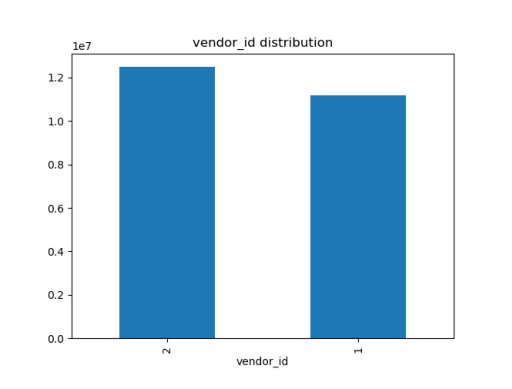

In [7]:
# plot
plot_bar(df, 'vendor_id', 'explor/vendor_id_dist.png', retrieve_if_exists=True)

### Tpep_pickup_datetime & Tpep_dropoff_datetime
Date and time of pickup and dropoff. I want to see if the data is consistent

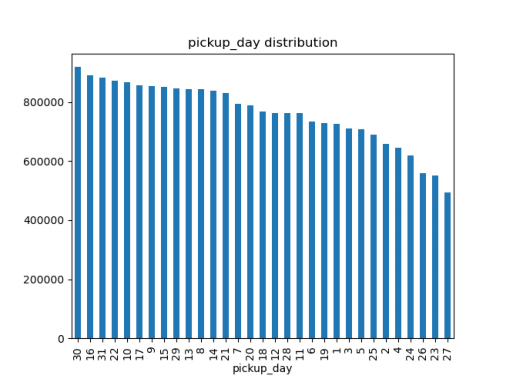

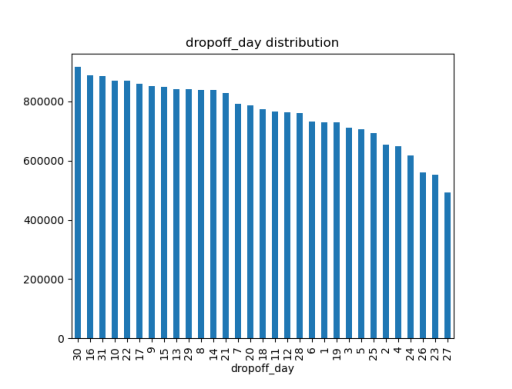

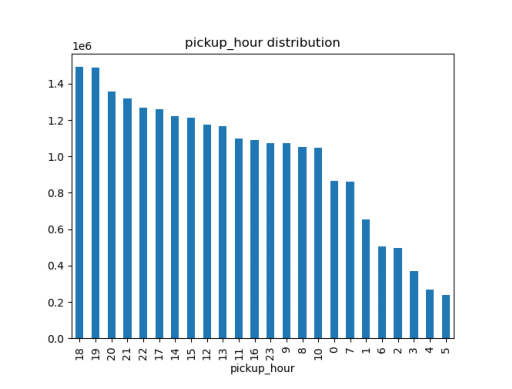

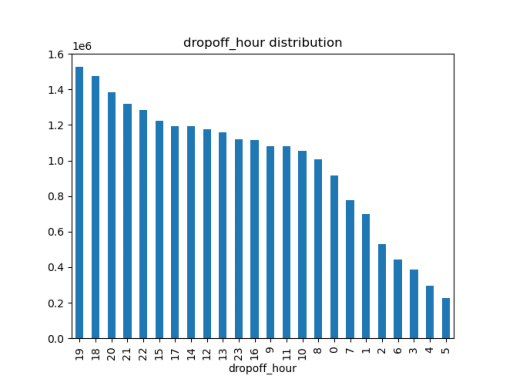

In [8]:
# Extract day and hour information
df['pickup_day'] = df['tpep_pickup_datetime'].dt.day
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
df['dropoff_day'] = df['tpep_dropoff_datetime'].dt.day
df['dropoff_hour'] = df['tpep_dropoff_datetime'].dt.hour

plot_bar(df, 'pickup_day', 'explor/pickup_day.png', retrieve_if_exists=True)
plot_bar(df, 'dropoff_day', 'explor/dropoff_day.png', retrieve_if_exists=True)
plot_bar(df, 'pickup_hour', 'explor/pickup_hour.png', retrieve_if_exists=True)
plot_bar(df, 'dropoff_hour', 'explor/dropoff_hour.png', retrieve_if_exists=True)

See elapsed time from pickup to dropoff. Too high time can be an error.

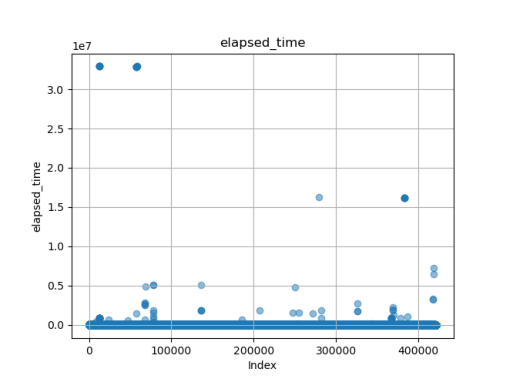

In [9]:
df['elapsed_time'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds()
plot_scatter(df, 'elapsed_time', 'explor/elapsed_time.png', retrieve_if_exists=True)

In [10]:
# calc quantiles
#quantiles = df.elapsed_time.quantile([0.004, 0.01, 0.997, 0.9978, 0.9979, 0.998]).compute()
#0.0040       22.0000
#0.0100       81.0000
#0.9970     6040.6099
#0.9978     6040.6099
#0.9979     6192.0000
#0.9980    85252.3520

### Passenger Count
The number of passengers in the vehicle (driver-entered value). Found out to be [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].

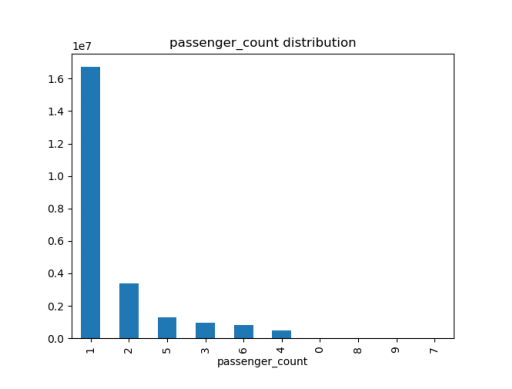

In [11]:
# get passenger_count value count
plot_bar(df, 'passenger_count', 'explor/passenger_count_dist.png', retrieve_if_exists=True)

### Trip distance
The elapsed trip distance in miles reported by the taximeter. This can be a tricky estimate and very long or zero distances are very unlucky to be actual real measurements.

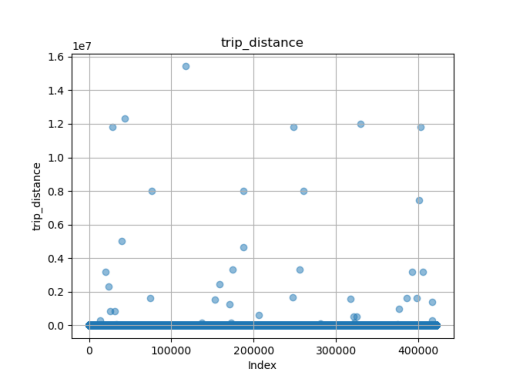

In [12]:
# plot the distribution of trip_distance
plot_scatter(df, 'trip_distance', 'explor/trip_distance_dist.png', retrieve_if_exists=True)

In [13]:
# threshold = df.trip_distance.quantile(0.999).compute()
# 26.97440000000177

### Speed
Calculate the speed to see if it is consistent.

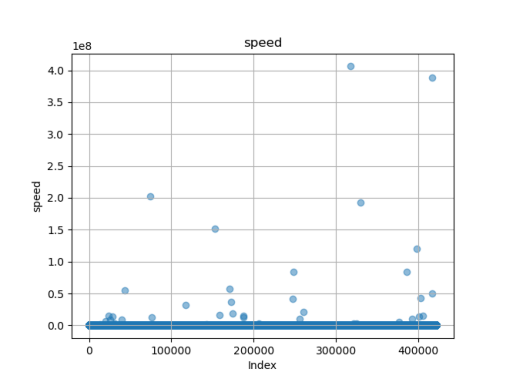

In [14]:
# To calculate speed I need to make sure that the time is greater than 0
df = df[df['elapsed_time'] > 0]
df['speed'] = df['trip_distance'] / (df['elapsed_time'] / 3600)
plot_scatter(df, 'speed', 'explor/speed_dist.png', retrieve_if_exists=True)

### Pickup and dropoff longitude and latitude
Longitude and latitude where the meter was engaged or disengaged. Latitude or longitude equal zeros are considered wrongly taken.

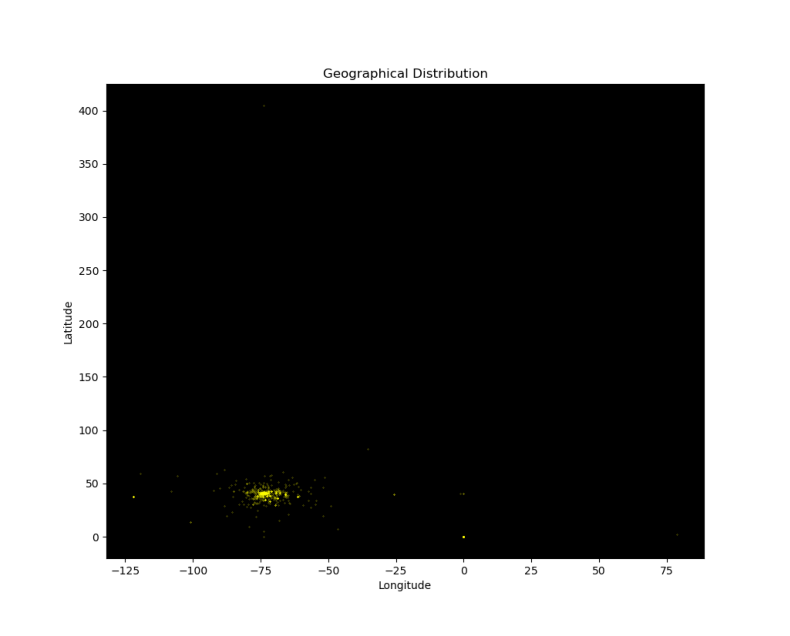

In [15]:
plot_map(df, 'pickup_longitude', 'pickup_latitude', 'explor/pickup_map.png', retrieve_if_exists=True)

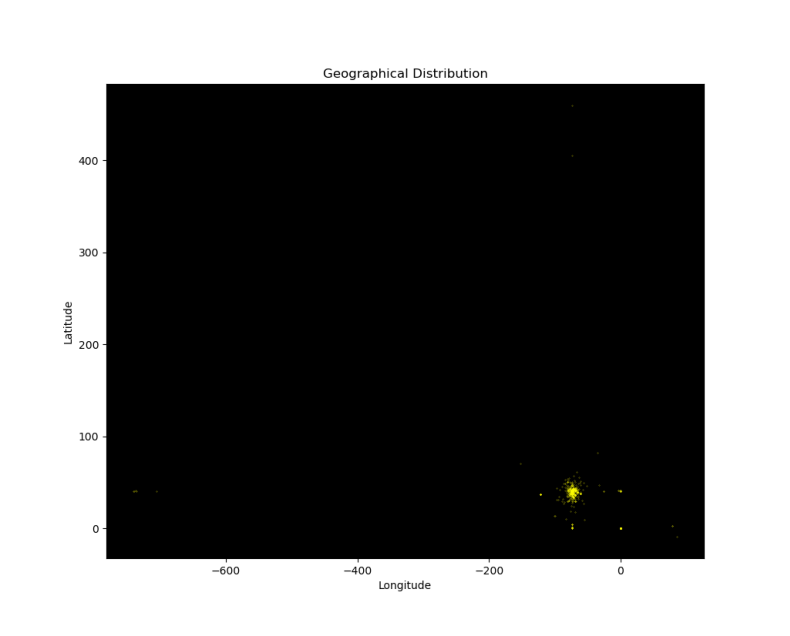

In [16]:
plot_map(df, 'dropoff_longitude', 'dropoff_latitude', 'explor/dropoff_map.png', retrieve_if_exists=True)

In [17]:
# Define the columns for which you want to calculate quantiles
#columns_of_interest = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']
#
## Compute quantiles with offset for selected columns
#offset = 0.01
## Extract quantile values for each column
#pickup_lat_quantiles = df['pickup_latitude'].quantile([offset, 1 - offset]).compute()
#pickup_long_quantiles = df['pickup_longitude'].quantile([offset, 1 - offset]).compute()
#dropoff_lat_quantiles = df['dropoff_latitude'].quantile([offset, 1 - offset]).compute()
#dropoff_long_quantiles = df['dropoff_longitude'].quantile([offset, 1 - offset]).compute()
#
## Extract specific quantile values with offset
#pickup_low_lat_quantile = pickup_lat_quantiles.loc[offset]
#pickup_high_lat_quantile = pickup_lat_quantiles.loc[1 - offset]
#pickup_low_long_quantile = pickup_long_quantiles.loc[offset]
#pickup_high_long_quantile = pickup_long_quantiles.loc[1 - offset]
#
#dropoff_low_lat_quantile = dropoff_lat_quantiles.loc[offset]
#dropoff_high_lat_quantile = dropoff_lat_quantiles.loc[1 - offset]
#dropoff_low_long_quantile = dropoff_long_quantiles.loc[offset]
#dropoff_high_long_quantile = dropoff_long_quantiles.loc[1 - offset]
#
#print(pickup_low_lat_quantile, pickup_high_lat_quantile, pickup_low_long_quantile, pickup_high_long_quantile)
#print(dropoff_low_lat_quantile, dropoff_high_lat_quantile, dropoff_low_long_quantile, dropoff_high_long_quantile)

# 40.645389556884766 40.80260848999024 -74.00971984863281 -73.7819061279297
# 40.651885986328125 40.82617347717285 -74.01116180419923 -73.78972625732422


### Rate Code ID
The final rate code in effect at the end of the trip.
1. Standard rate
2. JFK
3. Newark
4. Nassau or Westchester
5. Negotiated fare
6. Group ride

In the data there is also category 99, that is probably a missing or wrongly taken value that I will remove.

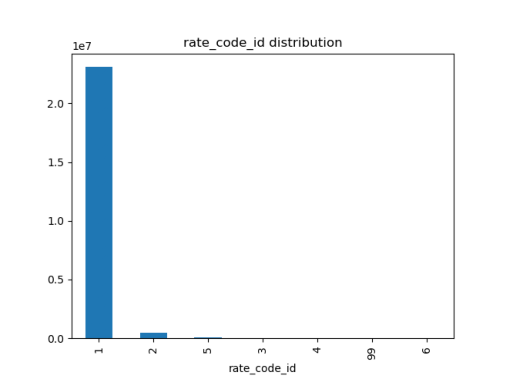

In [18]:
# get rate_code_id histogram
plot_bar(df, 'rate_code_id', 'explor/rate_code_id_dist.png', retrieve_if_exists=True)

### Store and forward flag
This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server. Y= store and forward trip N= not a store and forward trip. Can be transform into a boolean.


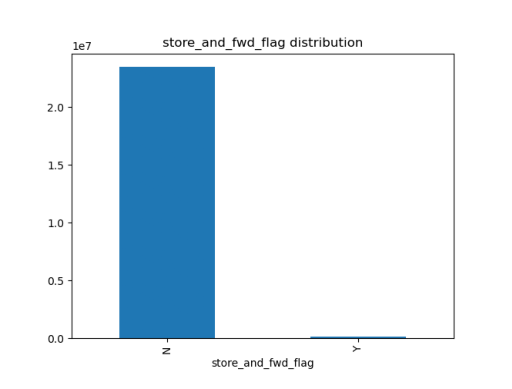

In [19]:
# get store_and_fwd_flag value count
plot_bar(df, 'store_and_fwd_flag', 'explor/store_and_fwd_flag_dist.png', retrieve_if_exists=True)

### Payment type
A numeric code signifying how the passenger paid for the trip.
1. Credit card
2. Cash
3. No charge
4. Dispute
5. Unknown
6. Voided trip

Can be changed to categorical

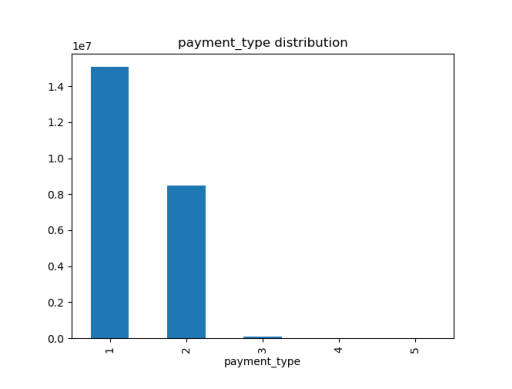

In [20]:
# get the payment_type value count
plot_bar(df, 'payment_type', 'explor/payment_type_dist.png', retrieve_if_exists=True)

#payment_type
#1    14762072
#2     8273959
#3       58474
#4       21312
#5           3

### Price
- Fare_amount : The time-and-distance fare calculated by the meter.
- Extra : Miscellaneous extras and surcharges.
- MTA_tax : 0.50 MTA tax that is automatically triggered based on the metered rate in use.
- Improvement_surcharge : 0.30 improvement surcharge.
- Tip_amount : Tip amount (only card)
- Tolls_amount : Total amount of all tolls paid in trip.
- Total_amount : The total amount charged to passengers. Does not include cash tips.

Fare amount:

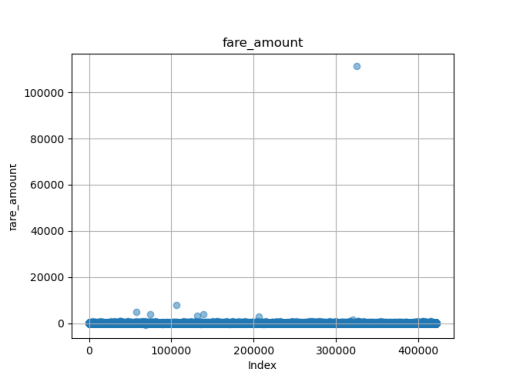

In [21]:
# get the fare_amount summary
plot_scatter(df, 'fare_amount', 'explor/fare_amount_dist.png', retrieve_if_exists=True)

In [22]:
#threshold = df.fare_amount.quantile(0.999).compute()
# 97.0

Extra:

In [23]:
# get the extra count per value
#extra_count = df.extra.value_counts().compute()
#print(extra_count)

#extra
# 0.00      12113786
# 0.50       7617167
# 1.00       3381221
#-0.50          2325
#-1.00           784
# 0.01           185
# 1.50           168
# 0.02            62
# 2.00            21
# 4.50            19
# 0.04             9
# 2.50             6
# ...

MTA tax:

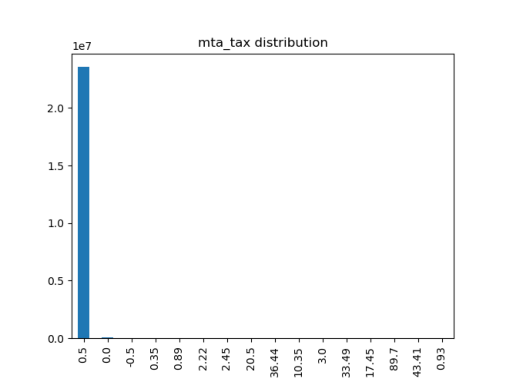

In [24]:
# found values: [0.5, 0.0, -0.5, 0.89]

# Count the amount of data for each value found in the variable
plot_bar(df, 'mta_tax', 'explor/mta_tax_dist.png', retrieve_if_exists=True)

#mta_tax
# 0.50     23048295
# 0.00        61682
#-0.50         5841
# 0.89            1
# 10.35           1

Improvement surchange:

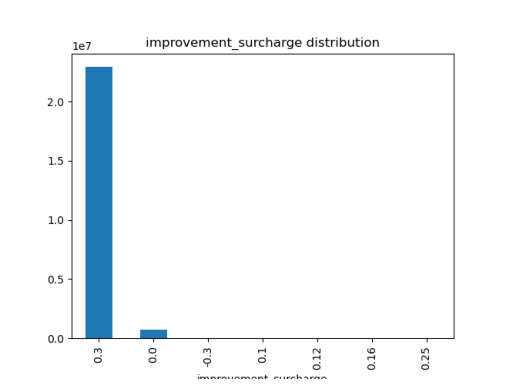

In [25]:
# Count the amount of data for each value found in the variable
plot_bar(df, 'improvement_surcharge', 'explor/improvement_surcharge_dist.png', retrieve_if_exists=True)

Tip amount:

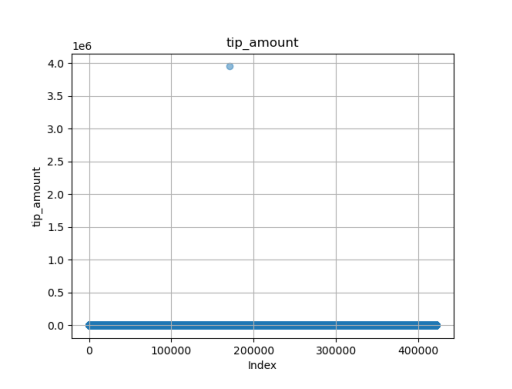

In [26]:
# get the tip_amount summary
plot_scatter(df, 'tip_amount', 'explor/tip_amount_dist.png', retrieve_if_exists=True)

In [27]:
#threshold = df.tip_amount.quantile(0.999).compute()
# 20

Tolls amount:

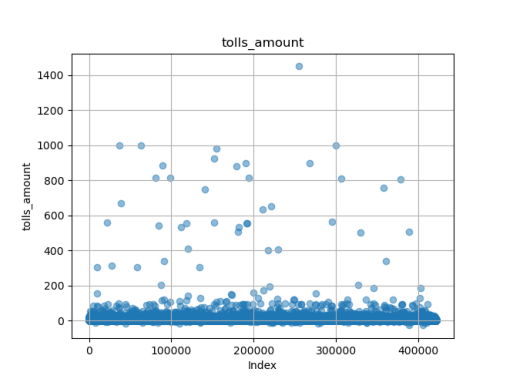

In [28]:
# get the tolls_amount summary
plot_scatter(df, 'tolls_amount', 'explor/tolls_amount_dist.png', retrieve_if_exists=True)

In [29]:
#threshold = df.tolls_amount.quantile(0.999).compute()
# 15.6966000000044

Total amount:

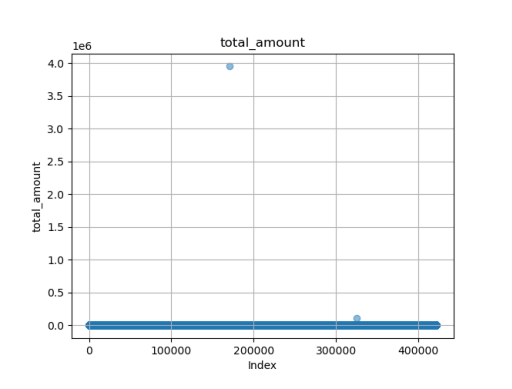

In [30]:
# get the total_amount summary
plot_scatter(df, 'total_amount', 'explor/total_amount_dist.png', retrieve_if_exists=True)

In [31]:
# threshold = df.total_amount.quantile(0.999).compute()
# 118.02595000000206

### Encoding
To save space and train faster. Smaller data types are easily readable and can be stored in memory.

In [32]:
# vendor_id to bool
df.vendor_id = df.vendor_id.map_partitions(lambda x: x == 2, meta=('vendor_id', 'bool'))

# store_and_fwd_flag to bool
df.store_and_fwd_flag = df.store_and_fwd_flag.map_partitions(lambda x: x == 'Y', meta=('store_and_fwd_flag', 'bool'))

In [33]:
# convert every float64 to float32
columns_to_convert = [col for col in df.columns if df[col].dtype == 'float64']
df[columns_to_convert] = df[columns_to_convert].map_partitions(lambda x: x.astype('float32'))

In [34]:
# convert dropoff_day, dropoff_hour, pickup_day, pickup_hour to int8
columns = ['dropoff_day', 
           'dropoff_hour', 
           'pickup_day', 
           'pickup_hour']
df[columns] = df[columns].map_partitions(lambda x: x.astype('int8'))

## Cleaning process

In [35]:
# Thresholds
trip_threshold = 80

# I decide to take the quantile values from the previous cell
low_lat_threshold = 40.5 # include staten island
high_lat_threshold = 40.91  # reach yonkers
low_long_threshold = -74.21  # I will include staten island and newark airport
high_long_threshold = -73.5   # include part of long island

fare_amount_threshold = 300

tip_amount_threshold = 100

tolls_amount_threshold = 50

# Total amount should be a combination of the other features
total_amount_threshold = fare_amount_threshold + tolls_amount_threshold + 10

lower_threshold = 30 # half a minute
upper_threshold = 9 * 3600 # 9 hours


Pickup and dropoff datatimes:

In [36]:
# remove the case in with pickup and dropoff times are exchanged
df = df[df.tpep_pickup_datetime < df.tpep_dropoff_datetime]

# remove outliers
df = df[df.elapsed_time > 0]
df = df[(lower_threshold < df.elapsed_time) & (df.elapsed_time < upper_threshold)]

# make it to int16
df.elapsed_time = df.elapsed_time.map_partitions(lambda x: x.astype('int16'))

Passenger count: No passenger, no trip (missing data)

In [37]:
# Remove no passenger data
df = df[df.passenger_count != 0]

# categorize the passenger_count
df.passenger_count = df.passenger_count.map_partitions(lambda x: x.astype('category'))
df.passenger_count = df.passenger_count.cat.set_categories([1, 2, 3, 4, 5, 6, 7, 8], ordered=True)

Trip distance: long distance trips are very uncommon (and can be associated with unreal data).

In [38]:
# remove outliers
df = df[(0 < df.trip_distance) & (df.trip_distance < trip_threshold)]

Speed limits: [0, 100]. More than 100 miles per hour in NY seems unreasonable

In [39]:
df = df[(df.speed < 100) & (df.speed > 0)]

Pickup and dropoff latitude and longitude: remove impossible latitudes and longitudes and define a range of variability by using the quantile

In [40]:
# I need to remove the location where latitude and longitude are not not possible
df = df[(-90 < df.pickup_latitude) & (df.pickup_latitude < 90) 
        & (-180 < df.pickup_longitude) & (df.pickup_longitude < 180) 
        & (-90 < df.dropoff_latitude) & (df.dropoff_latitude < 90) 
        & (-180 < df.dropoff_longitude) & (df.dropoff_longitude < 180)]

df = df[(low_lat_threshold < df.pickup_latitude) & (df.pickup_latitude < high_lat_threshold)
        & (low_long_threshold < df.pickup_longitude) & (df.pickup_longitude < high_long_threshold)
        & (low_lat_threshold < df.dropoff_latitude) & (df.dropoff_latitude < high_lat_threshold)
        & (low_long_threshold < df.dropoff_longitude) & (df.dropoff_longitude < high_long_threshold)]

Rate code ID: 99 is considered missing data

In [41]:
# original values: [1, 2, 3, 4, 5, 6, 99]
# 99 is unknown and should be removed
df = df[df.rate_code_id != 99]

df.rate_code_id = df.rate_code_id.map_partitions(lambda x: x.astype('category'))
df.rate_code_id = df.rate_code_id.cat.set_categories([1, 2, 3, 4, 5, 6], ordered=False)

Payment type: unknown type is considered missing data

In [42]:
# I can remove the payment_type 5 as it is unknown
df = df[df.payment_type != 5]

# Payment types from 3 to 6 are not common and should be removed
df = df[df.payment_type < 3]

# true if x = 1, false x == 2
df.payment_type = df.payment_type.map_partitions(lambda x: x == 1, meta=('payment_type', 'bool'))

Fare amount: negative or 0 amount are not possible. Very high outliers are unreasonable as well.

In [43]:
# remove outliers
df = df[(df.fare_amount > 0) & (df.fare_amount < fare_amount_threshold)]

Extra: negative extras and outliers are removed

In [44]:
# remove outliers (extra != 0, 0.5, 1)
df = df[(df.extra == 0) | (df.extra == 0.5) | (df.extra == 1)]

# to categorical
df.extra = df.extra.map_partitions(lambda x: x.astype('category'))
df.extra = df.extra.cat.set_categories([0, 0.5, 1], ordered=False)

MTA tax: A tax cannot be negative and should be common (not only 1 case). 

In [45]:
# remove outliers (mta_tax != 0.5, 0)
df = df[(df.mta_tax == 0.5) | (df.mta_tax == 0)]

# make it bool
df.mta_tax = df.mta_tax.map_partitions(lambda x: x.astype('bool'))

Improvement surchange: negative surchange and very unusual data is removed

In [46]:
# remove outliers (improvement_surcharge != 0.3, 0)
df = df[(df.improvement_surcharge == 0.3) | (df.improvement_surcharge == 0)]

# make it bool
df.improvement_surcharge = df.improvement_surcharge.map_partitions(lambda x: x.astype('bool'))

Tip amount: I will remove negative tip amount and outliers

In [47]:
# remove impossible items (tip_amount < 0)
df = df[(0 <= df.tip_amount)]
# remove outliners
df = df[df.tip_amount < tip_amount_threshold]

Tolls amount:

In [48]:
# remove outliers (tolls_amount > threshold)
df = df[df.tolls_amount < tolls_amount_threshold]

Total amount:

In [49]:
df = df[(df.total_amount > 0) & (df.total_amount < total_amount_threshold)]

### Scatters Clean data

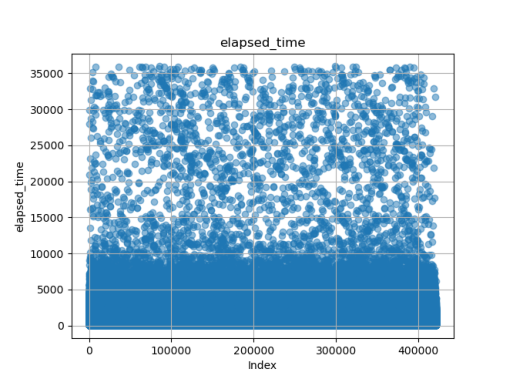

In [50]:
plot_scatter(df, 'elapsed_time', 'clean/elapsed_time.png', retrieve_if_exists=True)

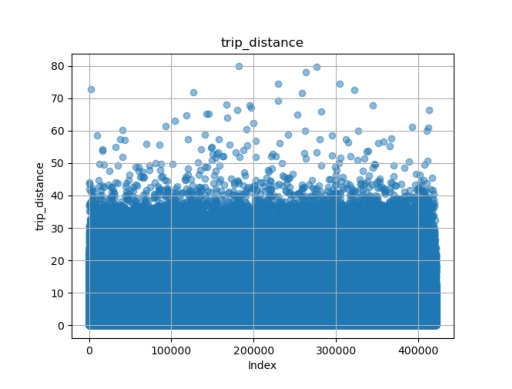

In [51]:
plot_scatter(df, 'trip_distance', 'clean/trip_distance_dist.png', retrieve_if_exists=True)

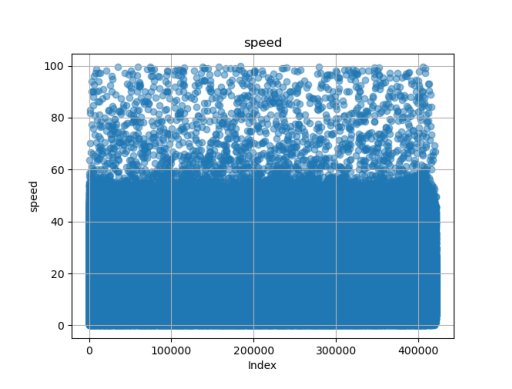

In [52]:
plot_scatter(df, 'speed', 'clean/speed_dist.png', retrieve_if_exists=True)

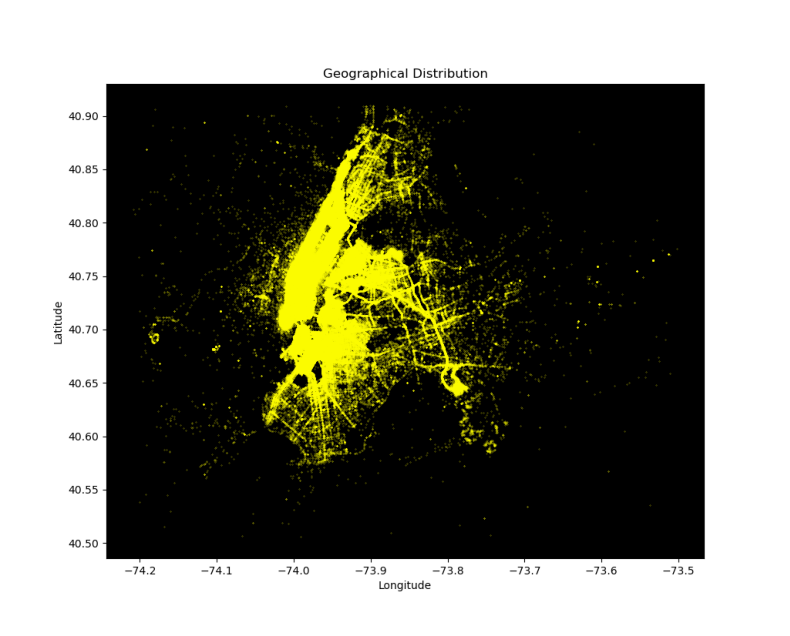

In [53]:
plot_map(df, 'pickup_longitude', 'pickup_latitude', 'clean/pickup_map.png', retrieve_if_exists=True)

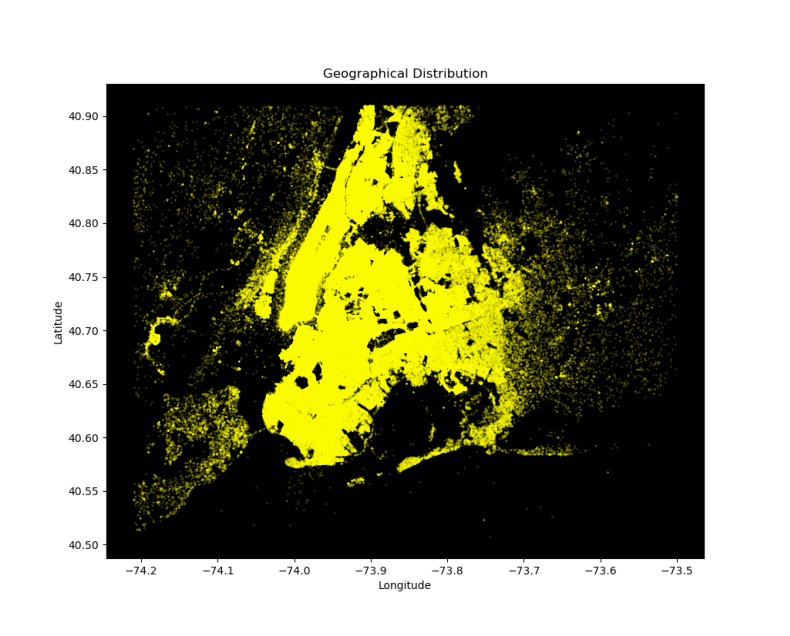

In [54]:
plot_map(df, 'dropoff_longitude', 'dropoff_latitude', 'clean/dropoff_map.png', retrieve_if_exists=True)

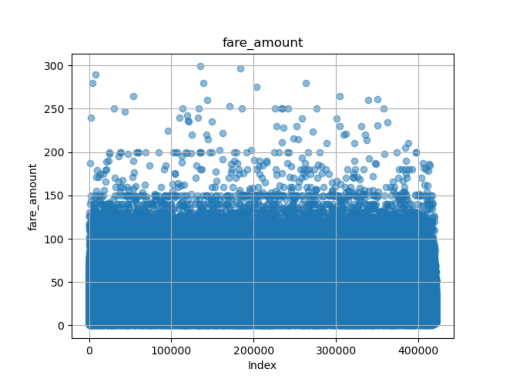

In [55]:
plot_scatter(df, 'fare_amount', 'clean/fare_amount_dist.png', retrieve_if_exists=True)

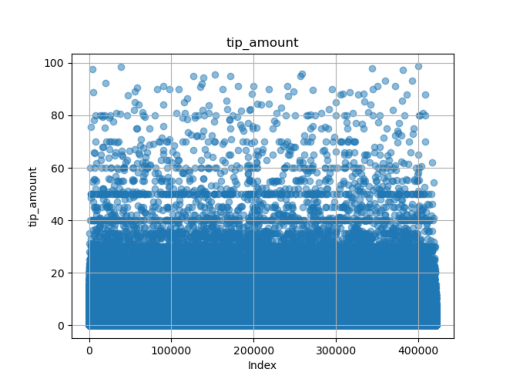

In [56]:
plot_scatter(df, 'tip_amount', 'clean/tip_amount_dist.png', retrieve_if_exists=True)

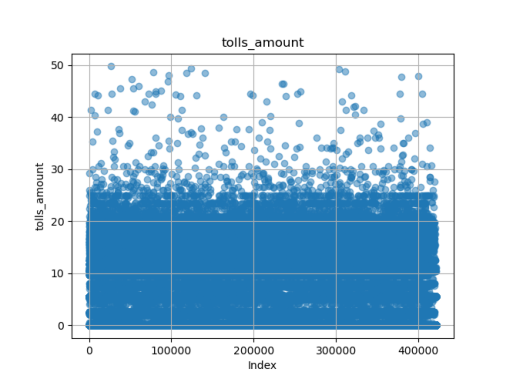

In [57]:
plot_scatter(df, 'tolls_amount', 'clean/tolls_amount_dist.png', retrieve_if_exists=True)

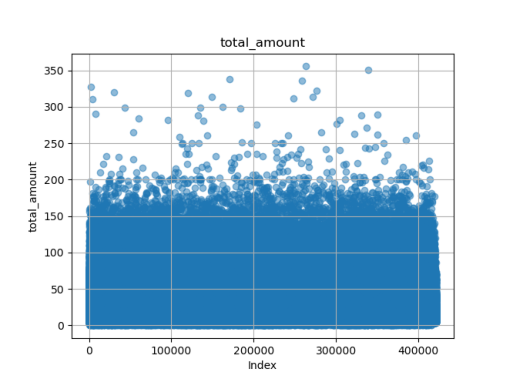

In [58]:
plot_scatter(df, 'total_amount', 'clean/total_amount_dist.png', retrieve_if_exists=True)

### Transform datatime
Pickup datetime will be encoded in different ways, while dropoff datetime will be converted in elapsed time from pickup datetime.

In [59]:
df['pickup_year'] = df['tpep_pickup_datetime'].dt.year
df['pickup_month'] = df['tpep_pickup_datetime'].dt.month
df['pickup_day_of_week'] = df['tpep_pickup_datetime'].dt.dayofweek
df['pickup_day'] = df['tpep_pickup_datetime'].dt.day
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
df['pickup_minute'] = df['tpep_pickup_datetime'].dt.minute
df['pickup_second'] = df['tpep_pickup_datetime'].dt.second

#Drop datetimes
df = df.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])
df = df.drop(columns=['dropoff_hour', 'dropoff_day'])

In [60]:
# Drop all nan values
df = df.dropna()

### Column selection

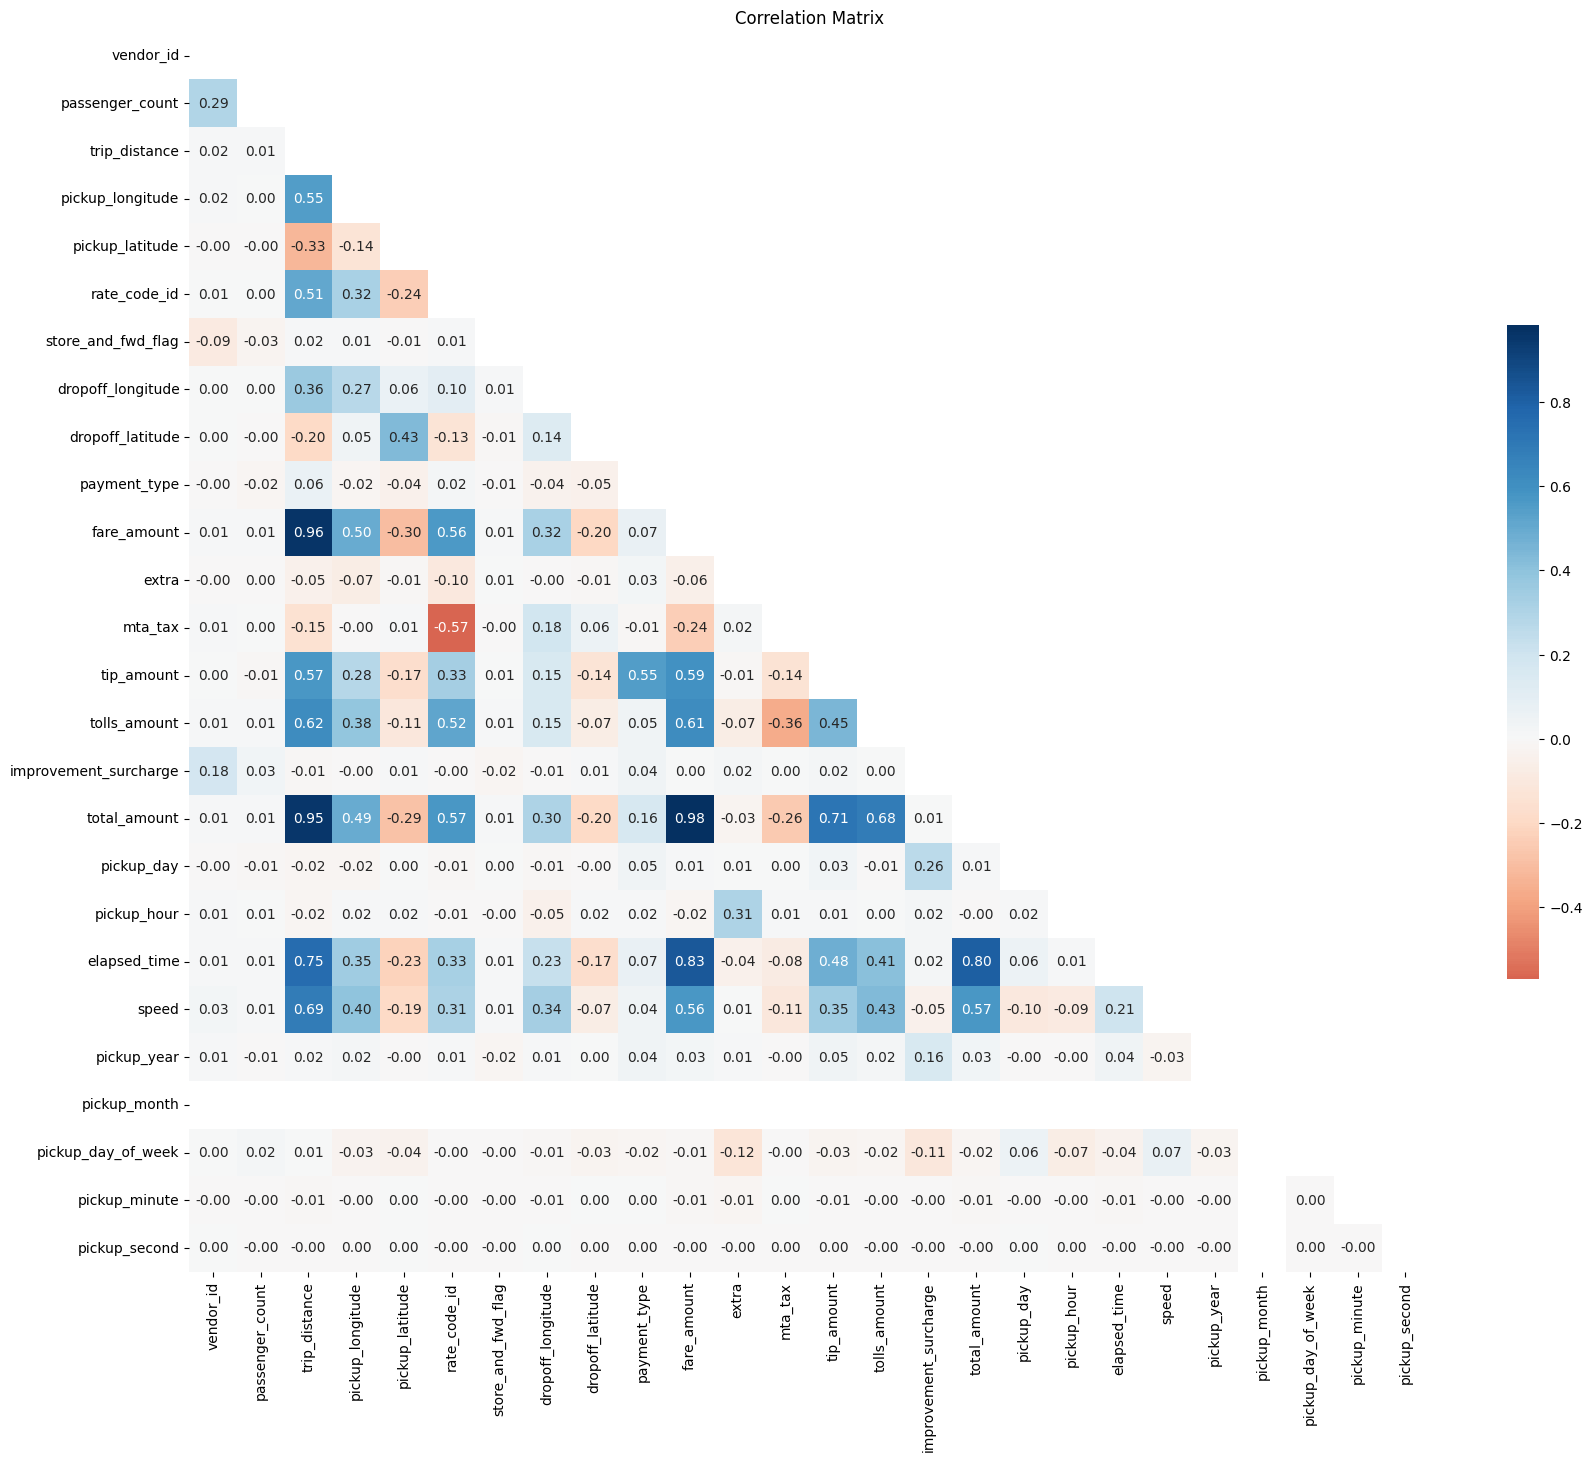

In [61]:
plot_correlation(df, 'select/correlation_all.png', retrieve_if_exists=True)

Remove those features that are combination of other features.

In [62]:
df = df.drop(columns=['speed', # Elapsed time / trip_distance (contain the actual distance, so it is unfair to include it)
                      'total_amount']) # linear combination of the other prices

I will also remove some features that I consider useless for my training based on the correlation matrix:

In [63]:
df = df.drop(columns=['pickup_second', # too precise
                      'pickup_minute', # too precise
                      'pickup_day', # encoded in pickup_day_of_week
                      'pickup_year', # not related
                      'pickup_month', # No variance
                      'store_and_fwd_flag', # Almost always N
                      'mta_tax', # Almost always 0.5
                      ]) 

Remove the trip_distance to provide information about correlation between features:

In [64]:
# Save the trip_distance column and drop it
if 'trip_distance' in df.columns:
    trip_distance = df['trip_distance']
    df = df.drop(columns=['trip_distance'])

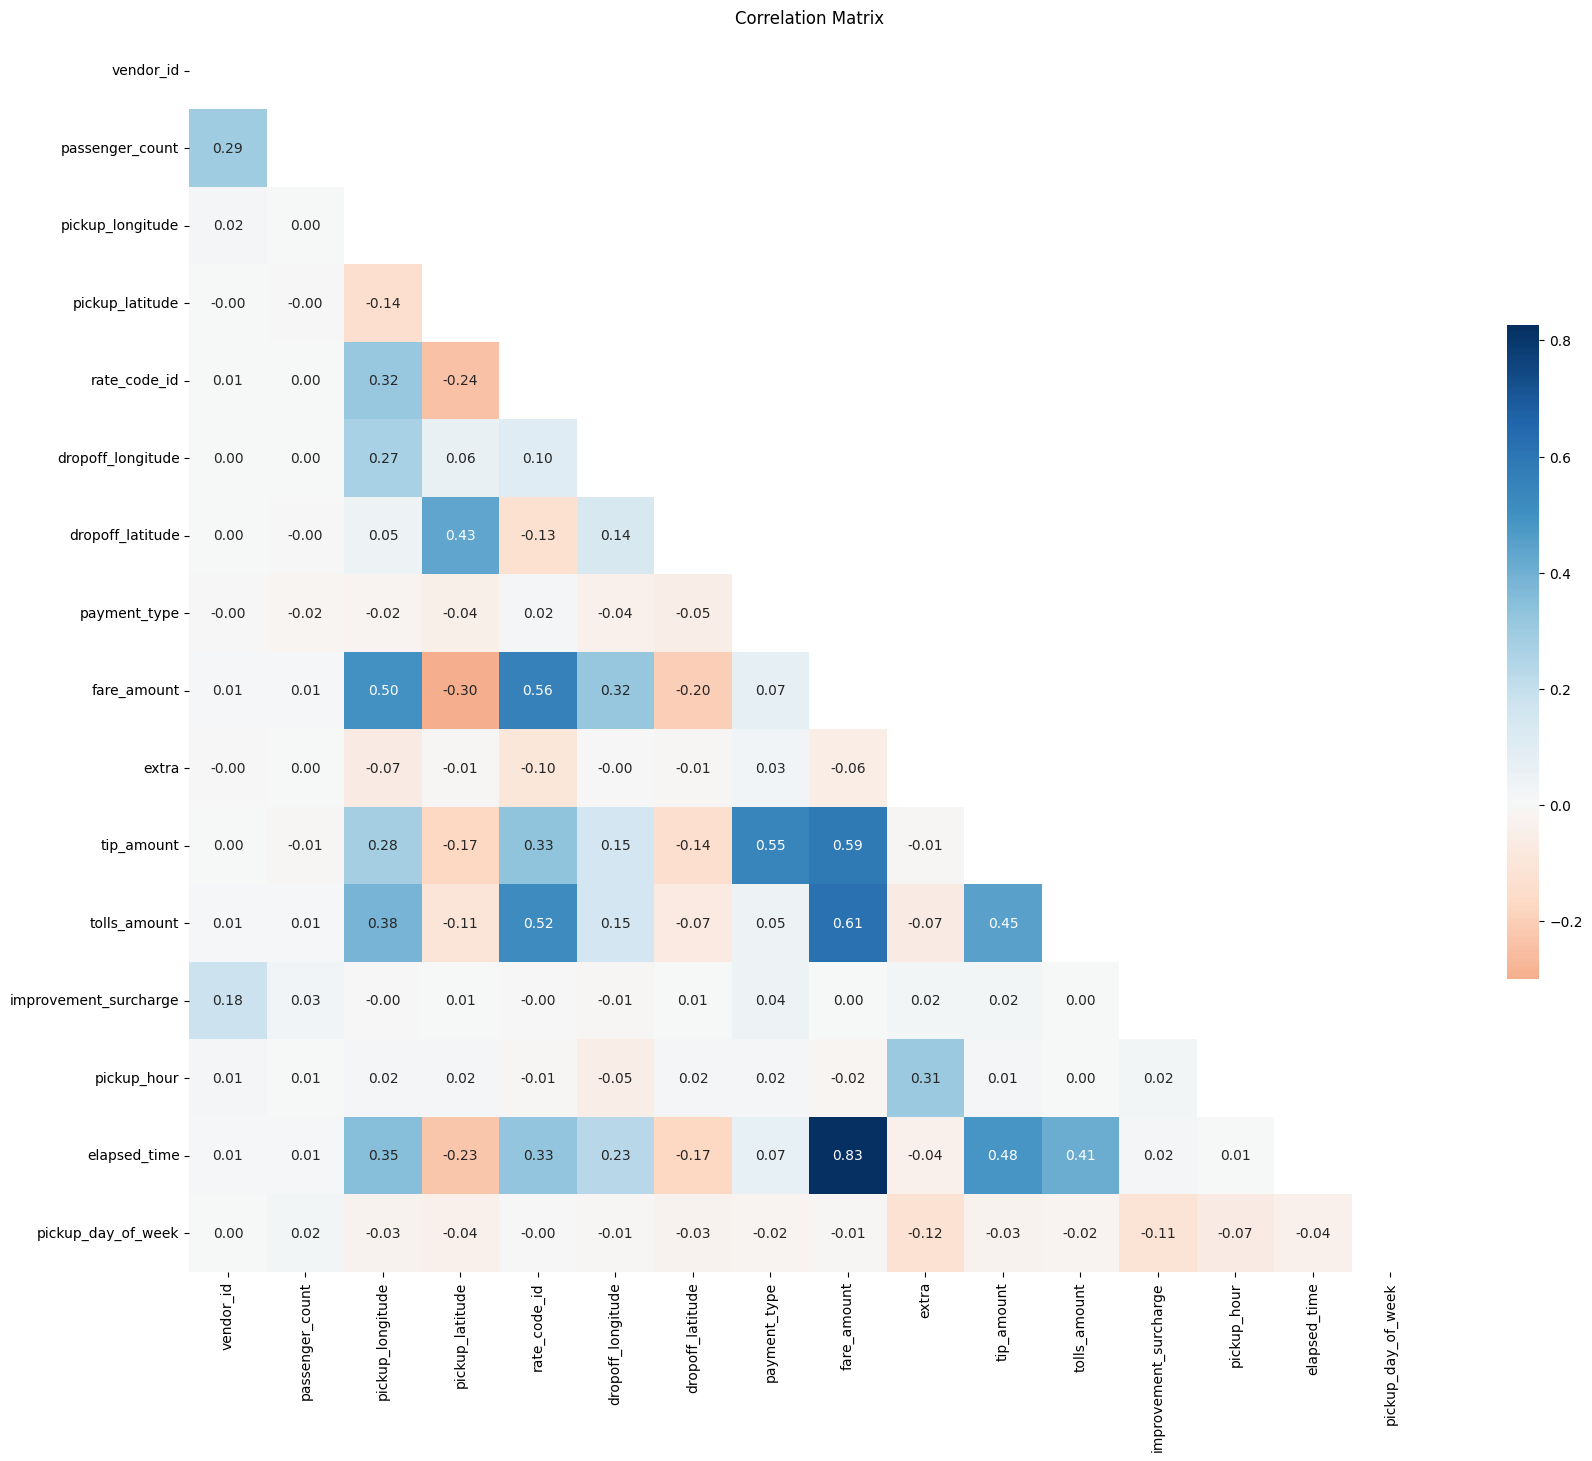

In [65]:
# Plot correlation matrix
plot_correlation(df, 'select/correlation_features.png', retrieve_if_exists=True)

### Standardize and Encode
I can use Standard Scaler because I have removed the outliers. Standardize data means performing: (x - mean) / std for each element.

In [66]:
float_columns = [col for col in df.columns if df[col].dtype == 'float32']
float_columns += ['elapsed_time']
scaler = StandardScaler()
df[float_columns] = scaler.fit_transform(df[float_columns])

One-hot encoding of not ordered categories with Dummy Encoder. It will create a different column for each category, removing the first one to not have correlation.

In [67]:
no_order_categorical_columns = ['rate_code_id']

df = df.categorize(columns=no_order_categorical_columns)
df = DummyEncoder(columns=no_order_categorical_columns,
                    drop_first=True).fit_transform(df)

Convert some columns to int8 to save space.

In [68]:
columns_to_int8 = ['pickup_day_of_week', 'pickup_hour', 'passenger_count']
df[columns_to_int8] = df[columns_to_int8].map_partitions(lambda x: x.astype('int8'))

Make extra floats for future training on numerical values.

In [69]:
# transform extra categorical to float
df.extra = df.extra.map_partitions(lambda x: x.astype('float32'))

Reinsert the trip distance to save to parquet

In [70]:
df['trip_distance'] = trip_distance

In [71]:
df.dtypes

vendor_id                   bool
passenger_count             int8
pickup_longitude         float32
pickup_latitude          float32
dropoff_longitude        float32
dropoff_latitude         float32
payment_type                bool
fare_amount              float32
extra                    float32
tip_amount               float32
tolls_amount             float32
improvement_surcharge       bool
pickup_hour                 int8
elapsed_time             float32
pickup_day_of_week          int8
rate_code_id_2              bool
rate_code_id_3              bool
rate_code_id_4              bool
rate_code_id_5              bool
rate_code_id_6              bool
trip_distance            float32
dtype: object

In [72]:
df.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,tip_amount,...,improvement_surcharge,pickup_hour,elapsed_time,pickup_day_of_week,rate_code_id_2,rate_code_id_3,rate_code_id_4,rate_code_id_5,rate_code_id_6,trip_distance
0,True,1,-0.540427,-0.035608,-0.020998,-0.040763,True,-0.007497,1.0,0.725751,...,True,19,0.520326,3,False,False,False,False,False,1.59
1,False,1,-0.752179,-0.982497,-0.608264,0.233371,True,0.248752,0.5,0.164861,...,True,20,0.696246,5,False,False,False,False,False,3.30
2,False,1,0.294286,1.892662,0.666009,2.341591,False,-0.263746,0.5,-0.732562,...,True,20,-0.268848,5,False,False,False,False,False,1.80
3,False,1,-0.955386,-1.364130,-0.904750,-1.029665,False,-0.878745,0.5,-0.732562,...,True,20,-1.076106,5,False,False,False,False,False,0.50
4,False,1,0.080241,0.415285,-0.900414,-0.297902,False,0.300002,0.5,-0.732562,...,True,20,0.645278,5,False,False,False,False,False,3.00


### Results of the cleaning process

In [78]:
initial_items = 23655844
n_items = df.shape[0].compute()
removed_items = initial_items - n_items
percent = (removed_items / initial_items) * 100
print(f"Final number of items: {n_items}")
print(f"Removed {removed_items} items ({percent:.2f}%)")

Final number of items: 22969143
Removed 686701 items (2.90%)


Cleaning process:
- Initial size: 23'655'844
- Final size: 22'969'143
- Items removed: 686'701
- Percent removed: 2.90%

### Save data
Saving data to a parquet to have it ready for after

In [79]:
# Compute and save the cleaned data as parquet
df.to_parquet('cleaned_data', engine='pyarrow')

## Training

Splitting the entire dataset into training and test sets. I will finetune the models only on the training set using grid search cross validation for linear and ridge regression and incremental search cross validation for the multi-layer perceptron (because for that I can use partial fit).

In [3]:
# Retrieve the cleaned data
df = dd.read_parquet('cleaned_data', engine='pyarrow')

train, test = train_test_split(df, test_size=0.2, random_state=42, shuffle=False, convert_mixed_types=True)

y_train = train['trip_distance'].persist()
X_train = train.drop(columns='trip_distance').persist()

y_test = test['trip_distance']
X_test = test.drop(columns='trip_distance')

# Reset index
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

### Linear Regression

Linear regression has only two available parameters for tuning:

In [ ]:
params = {'fit_intercept': [True, False]}

linear_model = GridSearchCV(LinearRegression(), param_grid=params, cv=3)

linear_model.fit(X_train, y_train)

Result best parameter:

In [5]:
print('Best parameters:')
print(linear_model.best_params_)
print('Best score:')
print(linear_model.best_score_)

# Best parameters:
# {'fit_intercept': True}
# Best score:
# 0.9501759267957365

Best parameters:
{'fit_intercept': True}
Best score:
0.9501759267957365


### Ridge Regression

For ridge regression I will tune the alpha parameter, the tolerance and the solver used.

In [ ]:
# Perform ridge regression
params = {'alpha': [2.0, 3.0, 4.0, 5.0], 
          'tol': [1e-7, 1e-6, 1e-5],
          'solver': ['auto', 'svd']
          }

ridge_model = GridSearchCV(Ridge(random_state=42, fit_intercept=True), param_grid=params, cv=3)
ridge_model.fit(X_train, y_train)

Best model:

In [10]:
print('Best parameters:')
print(ridge_model.best_params_)
print('Best score:')
print(ridge_model.best_score_)

# Best parameters:
# {'alpha': 5.0, 'solver': 'auto', 'tol': 1e-07}
# Best score:
# 0.9501759830715276

Best parameters:
{'alpha': 5.0, 'solver': 'auto', 'tol': 1e-07}
Best score:
0.9501759830715276


### MLP Regressor

For MLP I will finetune the network with the hidden layers and activation functions, the optimizer (solver) and learning rate.

In [ ]:
params = { 'hidden_layer_sizes': [(100,), (200,)],
           'activation': ['tanh', 'relu'],
           'solver': ['adam'],
           'alpha': [0.00001, 0.0001],
           'learning_rate': ['adaptive'],
           'learning_rate_init': [0.0001, 0.001]}

mlp_model = IncrementalSearchCV(MLPRegressor(random_state=42), parameters=params, decay_rate=None)
mlp_model.fit(X_train, y_train)

Best model found:

In [9]:
print('Best parameters:')
print(mlp_model.best_params_)
print('Best score:')
print(mlp_model.best_score_)

# Best parameters:
# {'solver': 'adam', 'learning_rate_init': 0.001, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (200,), 'alpha': 0.0001, 'activation': 'relu'}
# Best score:
# 0.9895072887359625

Best parameters:
{'solver': 'adam', 'learning_rate_init': 0.001, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (200,), 'alpha': 0.0001, 'activation': 'relu'}
Best score:
0.9895072887359625


## Evaluation
To evaluate the model I will retrain using the best parameters found for each model and calculate the mean squared error using the test set (a set never used before).

In [ ]:
# Evaluate models
model_names = ['Linear Regression', 
               'Ridge Regression', 
               'MLP']
params = [{'fit_intercept': True}, 
          {'alpha': 5.0, 'solver': 'auto', 'tol': 1e-07}, 
          {'solver': 'adam', 'learning_rate_init': 0.001, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (200,), 'alpha': 0.0001, 'activation': 'relu'}]

models = [  ParallelPostFit(LinearRegression(**params[0])), 
            ParallelPostFit(Ridge(random_state=42, fit_intercept=True, **params[1])), 
            ParallelPostFit(Incremental(MLPRegressor(random_state=42, **params[2])))
            ]

for name, model in zip(model_names, models):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred.compute_chunk_sizes()
    mse = mean_squared_error(y_test, y_pred)
    print(f'{name} MSE: {mse}')

# Linear Regression MSE: 0.5866589546203613
# Ridge Regression MSE: 0.5866574645042419
# MLP MSE: 0.1213328093290329

The MLP perform better than the others. Training and test sets fits into memory, so I decided not to use the cluster in this case.

## Features Importance
Feature importances are calculated using two different methods to compare the results: Random Forests and XGBoost. To calculate the feature importances I have decided to fit using the all dataset without splitting it, because I don't want to focus on the performances, but on the correlations between the features and the output.

In [3]:
rf_imp_filename = 'rf_importances.pkl'
xgboost_imp_filename = 'xgboost_importances.pkl'

# Retrieve the cleaned data
df = dd.read_parquet('cleaned_data', engine='pyarrow')

X, y = df.drop(columns='trip_distance'), df['trip_distance']

X = X.copy().compute()
y = y.copy().compute()

In [4]:
import plotly.graph_objects as go

def plot_importances(X, imp_filename):
    if os.path.isfile(imp_filename):
        with open(imp_filename, 'rb') as f:
            importances = pickle.load(f)
    else:
        assert False, "No file found"
    indices = np.argsort(importances)[::-1]

    fig = go.Figure(data=[
        go.Bar(x=X.columns[indices], y=importances[indices])
    ])
    fig.update_layout(title_text='Feature importances', xaxis_tickangle=-45)
    fig.show()


In [ ]:
# Calculate feature importance using RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=7)
rf_model.fit(X, y)
importances = rf_model.feature_importances_
with open(rf_imp_filename, 'wb') as f:
    pickle.dump(importances, f)

In [7]:
plot_importances(X, rf_imp_filename)

The most important feature is the fare_amount, followed by elapsed_time. Rate Code ID and pickup/ dropoff location follows. This results follows the meaning of fare_amount. In fact fare amount should be a value that combine the distance and time of the trip, so to calculate the trip_distance we could just use the fare_amount and elapsed_time if the formula was known. Pickup and dropoff location are less important for this model, but probably because it is difficult to find the exact correlation between them to retrieve the distance.

In [4]:
# Retrieve the feature importance using XGBoost
xgb_model = XGBRegressor(n_estimators=100, random_state=42, max_depth=5)
xgb_model.fit(X, y)
importances = xgb_model.feature_importances_

# Save the feature importances using pickle
with open(xgboost_imp_filename, 'wb') as f:
    pickle.dump(importances, f)

/home/cristian/miniconda3/envs/test/lib/python3.10/site-packages/xgboost/core.py:248: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()


In [ ]:
plot_importances(X, xgboost_imp_filename)